In [2]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from matplotlib import ticker

In [3]:
datasets = ['adressa', 'cosmeticsshop', 'recsys2015']
scenario = 'timed' # one of timed and leave-last-one-out

In [4]:
optimisation_results = []
final_results = []
for dataset in datasets:
    results_path = f"results/{dataset}_timed" if scenario == 'timed' else f"results/{dataset}"
    opt = pd.read_json(f"{results_path}/optimisation_results.json")
    opt['dataset'] = dataset
    optimisation_results.append(opt)
    fin = pd.read_json(f"{results_path}/results.json")
    fin = fin.reset_index().rename(columns={'index': 'identifier'})
    fin['dataset'] = dataset
    final_results.append(fin)

optimisation_results_df = pd.concat(optimisation_results, ignore_index=True)
optimisation_results_df['algorithm'] = optimisation_results_df.identifier.apply(lambda x: x.split('(')[0])
final_results_df = pd.concat(final_results, ignore_index=True)
final_results_df['algorithm'] = final_results_df.identifier.apply(lambda x: x.split('(')[0])
final_results_df = final_results_df.sort_values('ndcgk_10', ascending=False).groupby(['algorithm', 'dataset']).first().reset_index()

In [5]:
def table_styler(styler, precision=2):
    styler.applymap_index(
        lambda v: "font-weight: bold;", axis="columns"
    )
    # fp precision 
    styler.format(precision=precision)
    return styler

def column_rename(column_name):
    """For ease of reading we change some columns before rendering them in latex"""
    name_mapping = {
        'recsys2015': 'Yoochoose',
        'adressa': 'Adressa',
        'cosmeticsshop': 'CosmeticsShop',
    }
    return name_mapping.get(column_name, column_name)

def algorithm_rename(algo_name):
    name_mapping = {
        # 'TARSItemKNNDing': 'IKNN Ding',
        # 'TARSItemKNNLiu': 'IKNN Liu',
        # 'SequentialRules': 'SR',
        'EASE': 'EASE\\textsuperscript{r}'
    }
    return name_mapping.get(algo_name, algo_name)


def table_styler_latex(styler, precision=2):
    styler = table_styler(styler, precision)
    # Replace inf with $\infty$ for proper rendering
    styler.format_index(lambda v: column_rename(v), axis='columns')
    # overwrite formatter to replace algorithm names.
    styler.format_index(algorithm_rename, axis='index')

    return styler

def make_results_table(df, metric, key='algorithm', percentage=False):
    render_df = df.pivot(key, columns=['dataset'], values=metric)[datasets]
    if percentage:
        render_df = render_df*100 # get percentages
    return render_df
    
def render_metric_table(df, metric, key='algorithm', latex=False, percentage=False, precision=2):
    res_table = make_results_table(df, metric, key=key, percentage=percentage)
    if latex:
        t = table_styler_latex(res_table.style, precision=precision).to_latex(multicol_align='c', hrules=True, convert_css=True)
        return t
    else:
        return table_styler(res_table.style, precision=precision)


In [6]:
render_metric_table(final_results_df, 'ndcgk_10', percentage=True)

dataset,adressa,cosmeticsshop,recsys2015
algorithm,,,
TARSItemKNN,18.48,4.46,10.73
TARSItemKNNDing,1.53,4.28,9.18
TARSItemKNNLee_W3,0.93,3.48,8.37
TARSItemKNNLee_W5,0.56,3.48,7.92
TARSItemKNNLiu,3.04,3.49,8.81
TARSItemKNNLiu2012,0.46,3.42,8.68
TARSItemKNNVaz,1.50,3.05,6.51


In [203]:
print(
    render_metric_table(
        final_results_df, 
        'ndcgk_10', 
        percentage=True, 
        latex=True
    )
)

\begin{tabular}{lrrr}
\toprule
dataset & \bfseries Adressa & \bfseries CosmeticsShop & \bfseries Yoochoose \\
algorithm &  &  &  \\
\midrule
TARSItemKNN & 12.05 & 6.43 & 18.53 \\
\bottomrule
\end{tabular}



In [204]:
params_df = pd.concat([optimisation_results_df, pd.DataFrame(optimisation_results_df['params'].tolist())], axis=1)
params_df.decay_interval.fillna(1, inplace=True)

In [205]:
params_df[(params_df.algorithm == 'TARSItemKNN') & (params_df.dataset == 'recsys2015')].sort_values('fit_decay', ascending=False)

,identifier,params,ndcgk_10,dataset,algorithm,fit_decay,predict_decay,similarity,decay_function,decay_interval
1267,"TARSItemKNN(K=200,decay_function=linear_steepe...","{'fit_decay': 1000, 'predict_decay': 1000, 'si...",0.000007,recsys2015,TARSItemKNN,1000.0,1000.0,conditional_probability,linear_steeper,NaN
1261,"TARSItemKNN(K=200,decay_function=linear_steepe...","{'fit_decay': 1000, 'predict_decay': 10, 'simi...",0.004952,recsys2015,TARSItemKNN,1000.0,10.0,conditional_probability,linear_steeper,NaN
1256,"TARSItemKNN(K=200,decay_function=linear_steepe...","{'fit_decay': 1000, 'predict_decay': 1, 'simil...",0.084380,recsys2015,TARSItemKNN,1000.0,1.0,cosine,linear_steeper,NaN
1257,"TARSItemKNN(K=200,decay_function=linear_steepe...","{'fit_decay': 1000, 'predict_decay': 1, 'simil...",0.093156,recsys2015,TARSItemKNN,1000.0,1.0,conditional_probability,linear_steeper,NaN
1258,"TARSItemKNN(K=200,decay_function=linear_steepe...","{'fit_decay': 1000, 'predict_decay': 5, 'simil...",0.009093,recsys2015,TARSItemKNN,1000.0,5.0,cosine,linear_steeper,NaN
...,...,...,...,...,...,...,...,...,...,...
1273,"TARSItemKNN(K=200,decay_function=inverse,decay...","{'decay_interval': 86400, 'similarity': 'condi...",0.121250,recsys2015,TARSItemKNN,NaN,NaN,conditional_probability,inverse,86400.0
1274,"TARSItemKNN(K=200,decay_function=inverse,decay...","{'decay_interval': 604800, 'similarity': 'cosi...",0.088258,recsys2015,TARSItemKNN,NaN,NaN,cosine,inverse,604800.0
1275,"TARSItemKNN(K=200,decay_function=inverse,decay...","{'decay_interval': 604800, 'similarity': 'cond...",0.121250,recsys2015,TARSItemKNN,NaN,NaN,conditional_probability,inverse,604800.0
1276,"TARSItemKNN(K=200,decay_function=inverse,decay...","{'decay_interval': 2592000, 'similarity': 'cos...",0.088258,recsys2015,TARSItemKNN,NaN,NaN,cosine,inverse,2592000.0


In [206]:
params_df[params_df.algorithm == 'TARSItemKNN'].sort_values('ndcgk_10', ascending=False).groupby(['dataset', 'algorithm']).first().reset_index()

,dataset,algorithm,identifier,params,ndcgk_10,fit_decay,predict_decay,similarity,decay_function,decay_interval
0,adressa,TARSItemKNN,"TARSItemKNN(K=200,decay_function=exponential,d...","{'fit_decay': 9.25926e-05, 'predict_decay': 0,...",0.133955,9.259260e-05,0.000000,conditional_probability,exponential,2592000.0
1,cosmeticsshop,TARSItemKNN,"TARSItemKNN(K=200,decay_function=exponential,d...","{'fit_decay': 0, 'predict_decay': 0.0002777778...",0.064796,0.000000e+00,0.000278,cosine,exponential,86400.0
2,recsys2015,TARSItemKNN,"TARSItemKNN(K=200,decay_function=exponential,d...","{'fit_decay': 8.267000000000001e-07, 'predict_...",0.148814,8.267000e-07,0.000278,cosine,exponential,2592000.0


In [180]:
HOUR = 3600  # seconds
DAY = 24 * HOUR
[
    1 / x
    for x in [1 * HOUR, 2 * HOUR, 3 * HOUR, 6 * HOUR, 12 * HOUR, 1 * DAY, 7 * DAY, 14 * DAY, 30 * DAY]
]

[0.0002777777777777778,
 0.0001388888888888889,
 9.259259259259259e-05,
 4.6296296296296294e-05,
 2.3148148148148147e-05,
 1.1574074074074073e-05,
 1.6534391534391535e-06,
 8.267195767195768e-07,
 3.8580246913580245e-07]

In [211]:
from recpack.algorithms.time_aware_item_knn import decay_functions
import numpy as np

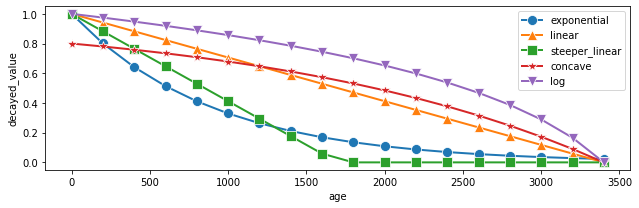

In [230]:
fig, ax = plt.subplots(1,1, figsize=(9, 3))
points = np.arange(0, 3600, 200)
for name, decayed, marker in [
    ("exponential", decay_functions.exponential_decay(points, 1/900), 'o'),
    ("linear", decay_functions.linear_decay(points, 1), '^'),
    ("steeper_linear", decay_functions.linear_decay_steeper(points, 2), 's'),
    ("concave", decay_functions.concave_decay(points, 0.2), '*'),
    ("log", decay_functions.log_decay(points, 8), 'v'),
]:
    seaborn.lineplot(x=points, y=decayed, ax=ax, label=name, linewidth=2, marker=marker, markersize=10)

ax.set_xlabel('age')
ax.set_ylabel('decayed_value')
fig.tight_layout()

fig.savefig('decay_functions.pdf', dpi=300, format='pdf')

In [ ]:
    
seaborn.lineplot(x=points, y=decayed, ax=ax, label=name, linewidth=2, fmt='-')

ax.set_xlabel('age')
ax.set_ylabel('decayed_value')

fig.savefig('decay_functions.pdf', dpi=300, format='pdf')